# Import Libaries

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
# import all necessary libraries
import os
import warnings
from pathlib import Path

import cartopy.feature as cfeature
import geodatasets
import geopandas as gpd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import xarray as xr
from joblib import Parallel, delayed
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
from statsmodels.graphics.tsaplots import plot_acf
from tqdm import tqdm
from utils.eda_helper_functions import plot_histogram

import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

from utils.eda_helper_functions import (
    check_missing_times,
    group_data_hourly,
    load_insitu_data,
    load_ocean_data,
    load_weather_data,
    plot_water_level_anomalies,
    process_df,
    process_flensburg_data,
    show_df,
)
from utils.config import (
    LAT_FLENSBURG,
    LON_FLENSBURG,
    SUB_BOX,
    OCEAN_DICT,
    WEATHER_DICT,
    INSITU_DICT,
    OCEAN_POINTS,
    WEATHER_POINTS,
    )

# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Display all columns
#pd.options.display.max_columns = None

plt.rcParams.update({
    "font.size": 14,                # Grundschriftgröße (wirkt auf alles, sofern nicht überschrieben)
    "axes.titlesize": 16,           # Größe des Titels der Achse (z.B. 'Subplot Title')
    "axes.labelsize": 14,           # Achsenbeschriftung (x/y label)
    "xtick.labelsize": 12,          # X-Tick-Beschriftung
    "ytick.labelsize": 12,          # Y-Tick-Beschriftung
    "legend.fontsize": 12,          # Legendentext
    "figure.titlesize": 18,         # Gesamttitel der Abbildung (plt.suptitle)
    "figure.labelsize": 14,         # (optional, selten verwendet)
    "savefig.dpi": 300,             # DPI beim Speichern
    "figure.dpi": 100,              # DPI bei Anzeige
})

OCEAN_POINTS = 30

ocean_data_path = Path(f"../data/numerical_data/points{OCEAN_POINTS}")
print(ocean_data_path)
weather_data_path = Path(f"../data/numerical_data/points{WEATHER_POINTS}")
print(weather_data_path)

# save df_merged to ../data/tabular_data_FI/
file_name = f'df_merged{OCEAN_POINTS}_FI.tsv'
output_path = Path('../data/tabular_data_FI/')


/gxfs_home/geomar/smomw693/Documents/GEOMAR-DeepLearning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


../data/numerical_data/points30
../data/numerical_data/points10


In [36]:
df_ocean = load_ocean_data(ocean_data_path, OCEAN_POINTS, verbose=False)
df_ocean = process_df(df_ocean, drop_cols=["depth"], verbose=False)

df_weather = load_weather_data(weather_data_path, WEATHER_POINTS, verbose=False)
df_weather = process_df(df_weather, verbose=False, drop_cols=['showers'])

df_insitu = load_insitu_data(verbose=False)
df_insitu = process_flensburg_data(df_insitu, 
                                      start_time=df_ocean['time'].min(),
                                      end_time=df_ocean['time'].max(),
                                      verbose=False)

df_insitu = group_data_hourly(df_insitu)
df_insitu = process_df(df_insitu, drop_cols=["depth",'deph', 'latitude', 'longitude', 'time_qc', 'slev_qc'], verbose=False)


df_weather5.nc removed


In [ ]:
df_weather.info()

In [ ]:
def feature_engineering(df_ocean, df_weather, df_insitu):
    """
    Funktion zur Berechnung der u- und v-Komponenten des Windes aus der Windgeschwindigkeit und -richtung.
    """
    
    # df_weather


    #Calculate Radial Wind Speed
    theta = np.deg2rad(df_weather['wind_direction_10m'])

    #Calculate u and v components
    #    Definition der u- und v-Komponenten:
    #    u = Windgeschwindigkeit * sin(Windrichtung)
    #    v = Windgeschwindigkeit * cos(Windrichtung)
    df_weather['wind_u'] = df_weather['wind_speed_10m'] * np.sin(theta)  # positiver Wert = Wind nach Osten
    df_weather['wind_v'] = df_weather['wind_speed_10m'] * np.cos(theta)  # positiver Wert = Wind nach Norden

    # Remove the original wind speed and direction columns
    df_weather.drop(columns=['wind_speed_10m', 'wind_direction_10m'], inplace=True)

    return df_ocean, df_weather, df_insitu


df_ocean, df_weather, df_insitu = feature_engineering(df_ocean, df_weather, df_insitu)

In [ ]:
def convert_df_to_table(df: pd.DataFrame) -> pd.DataFrame:


    df['position'] = df.apply(lambda row: (row['latitude'], row['longitude']), axis=1)
    coordinates = df['position'].unique()

    df_merged = pd.DataFrame({'time': df['time'].unique()})
    for i in tqdm(range(len(coordinates)), desc="Processing coordinates", unit="coord", total=len(coordinates)):

        df_sub_data = df[df['position'] == coordinates[i]]
        df_sub_data = df_sub_data.drop(columns=['latitude', 'longitude'])

        cols = df_sub_data.columns.tolist()
        cols.remove('position')
        cols.remove('time')


        for col in cols:
            df_sub_data.rename(columns={col: col + '#' + str(coordinates[i])}, inplace=True)

        df_sub_data = df_sub_data.drop(columns='position')


        df_merged = df_merged.merge(df_sub_data, on='time')
        
    return df_merged

In [ ]:
df_ocean_table = convert_df_to_table(df_ocean)
df_weather_table = convert_df_to_table(df_weather)


In [ ]:
print(f'\nShape of df_ocean before: {df_ocean.shape}')
print(f'Shape of df_ocean after: {df_ocean_table.shape}')
print(f'\nShape of df_weather before: {df_weather.shape}')
print(f'Shape of df_weather after: {df_weather_table.shape}')
print(f'\nShape of df_insitu before: {df_insitu.shape}')


In [ ]:
df_insitu

In [ ]:
def merge_dataframes(dfs: list) -> pd.DataFrame:
    """
    Merge multiple DataFrames on the 'time' column.
    """
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = merged_df.merge(df, on='time', how='inner')

    merged_df['time'] = pd.to_datetime(merged_df['time']).dt.strftime('%Y-%m-%d %H:%M:%S')
    return merged_df


df_merged = merge_dataframes([df_ocean_table, df_weather_table, df_insitu])

In [ ]:
df_merged.head()
df_merged.iloc[20155:20174]

In [ ]:
print(output_path, file_name)

In [ ]:

df_merged.to_csv(output_path / file_name, index=False, sep='\t')

In [ ]:
dd

## Feature Importance

In [2]:
# Load data
df_merged = pd.read_csv(output_path / file_name, sep='\t')

In [3]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20161 entries, 0 to 20160
Columns: 7039 entries, time to slev
dtypes: float64(7038), object(1)
memory usage: 1.1+ GB


In [4]:
df_merged.iloc[20155:20174]

time  bottomT#(53.724952697753906, 14.374895095825195)  \
20155  2025-03-21 19:00:00                                          5.979825   
20156  2025-03-21 20:00:00                                          5.965313   
20157  2025-03-21 21:00:00                                          5.952088   
20158  2025-03-21 22:00:00                                          5.939920   
20159  2025-03-21 23:00:00                                          5.927609   
20160  2025-03-22 00:00:00                                          5.911982   

       mlotst#(53.724952697753906, 14.374895095825195)  \
20155                                         4.088912   
20156                                         4.083583   
20157                                         4.089709   
20158                                         4.099528   
20159                                         4.105371   
20160                                         4.104805   

       siconc#(53.724952697753906, 14.374895095825195)  \
20155                                              0.0   
20156                                              0.0   
20157                                              0.0   
20158                                              0.0   
20159                                              0.0   
20160                                              0.0   

       sithick#(53.724952697753906, 14.374895095825195)  \
20155                                               0.0   
20156                                               0.0   
20157                                               0.0   
20158                                               0.0   
20159                                               0.0   
20160                                               0.0   

       sla#(53.724952697753906, 14.374895095825195)  \
20155                                     -0.050443   
20156                                     -0.055772   
20157                                     -0.049646   
20158                                     -0.039827   
20159                                     -0.033985   
20160                                     -0.034550   

       so#(53.724952697753906, 14.374895095825195)  \
20155                                     0.012969   
20156                                     0.012974   
20157                                     0.012978   
20158                                     0.012980   
20159                                     0.012983   
20160                                     0.012985   

       sob#(53.724952697753906, 14.374895095825195)  \
20155                                      0.012969   
20156                                      0.012974   
20157                                      0.012978   
20158                                      0.012980   
20159                                      0.012983   
20160                                      0.012985   

       thetao#(53.724952697753906, 14.374895095825195)  \
20155                                         5.979825   
20156                                         5.965313   
20157                                         5.952088   
20158                                         5.939920   
20159                                         5.927609   
20160                                         5.911982   

       uo#(53.724952697753906, 14.374895095825195)  ...  \
20155                                     0.006487  ...   
20156                                     0.021989  ...   
20157                                     0.038875  ...   
20158                                     0.055494  ...   
20159                                     0.055831  ...   
20160                                     0.046694  ...   

       cloud_cover#(57.820735931396484, 16.753246307373047)  \
20155                                                1.0      
20156                                                0.0      
20157                                                0.0      
20158    

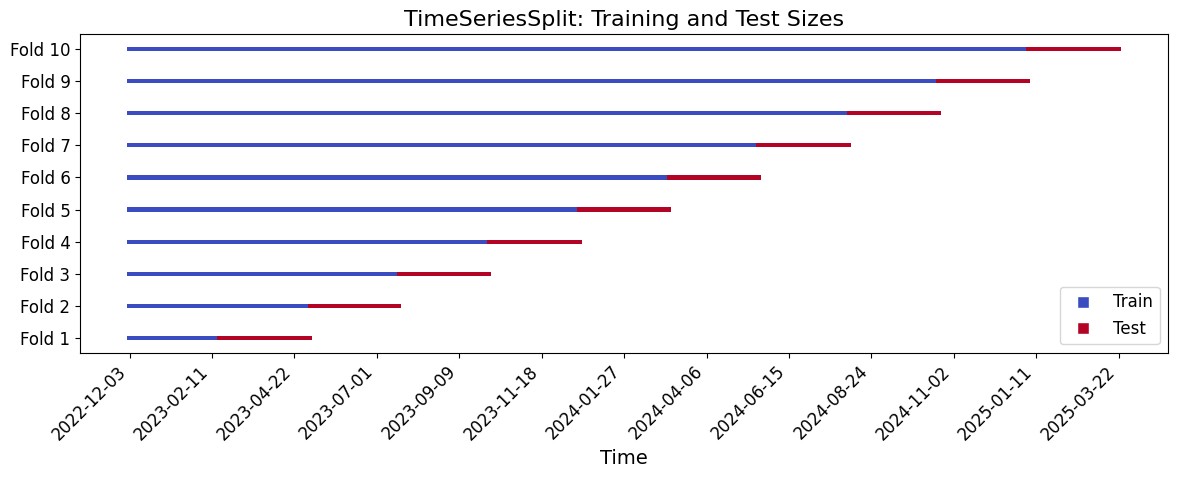

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

n_splits = 10
X = df_merged.drop(columns=["time", 'slev'])
times = pd.to_datetime(df_merged["time"]).dt.strftime('%Y-%m-%d').reset_index(drop=True)
tscv = TimeSeriesSplit(n_splits=n_splits)  # 7 Tage Testzeitraum, 24 Stunden pro Tag 

fig, ax = plt.subplots(figsize=(12, 5))
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    indices = np.full(len(X), np.nan)
    indices[train_index] = 0  # Trainingsdaten
    indices[test_index] = 1   # Testdaten
    ax.scatter(times, [i + 0.5] * len(X), c=indices, marker='s', cmap=plt.cm.coolwarm, lw=0, s=10)

ax.set_yticks(np.arange(n_splits) + 0.5)
ax.set_yticklabels([f"Fold {i+1}" for i in range(n_splits)])
ax.set_xlabel("Time")
ax.set_title("TimeSeriesSplit: Training and Test Sizes")

# X-Ticks reduzieren
max_xticks = 12  # z.B. 12 Ticks für Übersichtlichkeit
step = max(1, len(times) // max_xticks)
ax.set_xticks(times[::step])
ax.set_xticklabels(times[::step], rotation=45, ha='right')

ax.legend([plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=plt.cm.coolwarm(0.), markersize=8, label='Train'),
           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=plt.cm.coolwarm(1.), markersize=8, label='Test')],
          ['Train', 'Test'], loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:

## Hyperparameter-Tuning für RandomForestRegressor mit TimeSeriesSplit und Optuna
# Features und Zielvariable
X = df_merged.drop(columns=["time", "slev"])
y = df_merged["slev"]

n_trials = 10  # Anzahl der Versuche für das Hyperparameter-Tuning


In [7]:

# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 300),
#         "max_depth": trial.suggest_int("max_depth", 3, 50),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 30),
#         "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
#         "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
#         "random_state": 42,
#         "n_jobs": -1
#     }
#     model = RandomForestRegressor(**params)
#     scores = cross_val_score(model, X, y, cv=tscv, scoring="neg_mean_squared_error", n_jobs=-1)
#     return np.mean(scores)

# # Storage-URL für SQLite
# storage_url = "sqlite:///./optuna_study.db"
# study_name = f"water_level_rf_points{OCEAN_POINTS}_fi"

# # 2) Studie anlegen oder laden
# study = optuna.create_study(
#     study_name=study_name,     # optional
#     storage=storage_url,             # hier die DB-Verbindung
#     direction="maximize",
#     load_if_exists=True              # falls bereits vorhanden, weiterführen
# )
# study.optimize(objective, n_trials=n_trials)

# print("Beste Hyperparameter:", study.best_params)
# print("Bestes (negatives) MSE:", study.best_value)



In [8]:
# Open Study

# Storage-URL für SQLite
storage_url = "sqlite:///./optuna_study.db"
study_name = f"water_level_rf_points{OCEAN_POINTS}_fi"
study = optuna.load_study(
    study_name=study_name,
    storage=storage_url
)


### Optuna Visualisierungen: Optimierungsverlauf und Hyperparameter-Importanz

In [9]:
import optuna.visualization as vis

# Verlauf der Optimierung (Zielwert pro Trial)
fig1 = vis.plot_optimization_history(study)
fig1.show()

# Wichtigkeit der Hyperparameter
fig2 = vis.plot_param_importances(study)
fig2.show()


fig4 = vis.plot_parallel_coordinate(study)
fig4.show()

## Evaluate Best Model

In [10]:
# load best parames from optuna_study.db
def load_best_params_from_study(study):
    return study.best_params
best_params = load_best_params_from_study(study)
print("Geladene beste Hyperparameter aus der Studie:", best_params)

Geladene beste Hyperparameter aus der Studie: {'n_estimators': 194, 'max_depth': 39, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}


In [15]:
X = df_merged.drop(columns=["time", "slev"])
y = df_merged["slev"]

# Trainiere das finale Modell mit den besten Parametern
best_rf = RandomForestRegressor(**best_params)
# scoring = RMSE
scoring = "neg_root_mean_squared_error"

scores = cross_val_score(best_rf, X, y, cv=tscv, scoring=scoring, n_jobs=-1)

print("Finales (negatives) RMSE:", np.mean(scores))
print("Final Model Std:", np.std(scores))


Finales (negatives) RMSE: -0.10725906723274503
Final Model Std: 0.04188422191378288


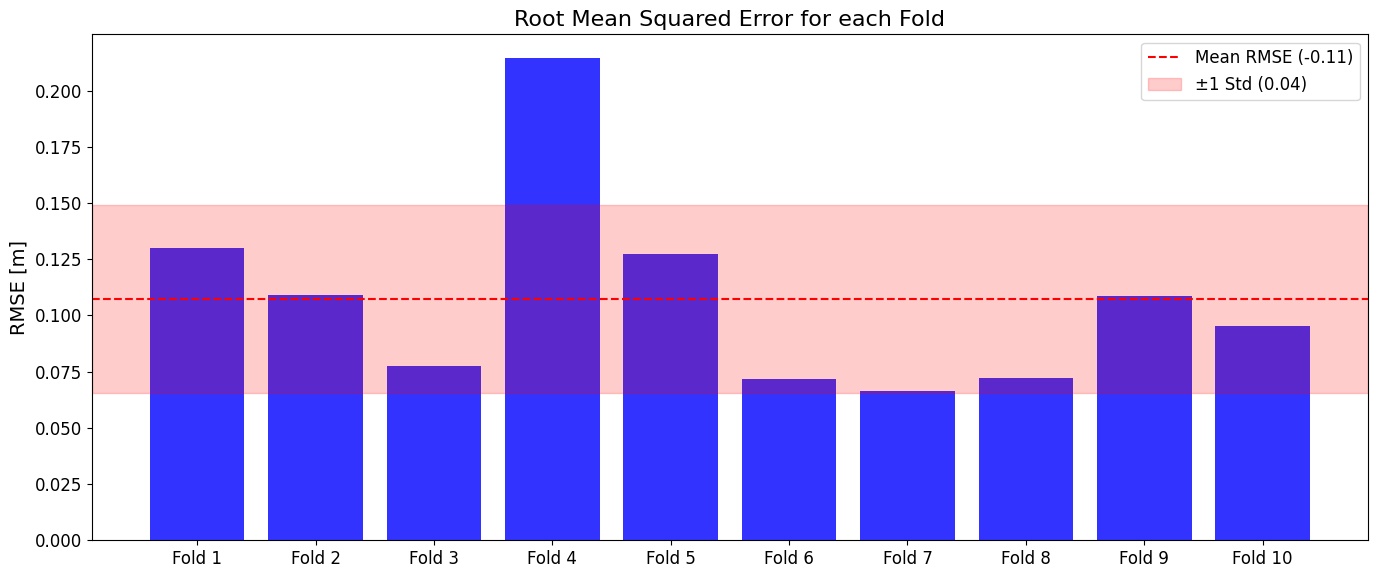

In [16]:
mu  = np.mean(scores)
sig = np.std(scores)


plt.figure(figsize=(14, 6))
plt.bar(
    range(len(scores)),
    -scores,
    color='blue',
    alpha=0.8
)
plt.ylabel("RMSE [m]")
plt.title("Root Mean Squared Error for each Fold")
plt.xticks(range(len(scores)), [f"Fold {i+1}" for i in range(len(scores))])

# Mean-Linie
plt.axhline(y=-mu, color='r', linestyle='--', label=f'Mean RMSE ({mu:.2f})')

# Schattiertes Band für +- 1 Std
plt.axhspan(-mu-sig, -mu+sig, color='r', alpha=0.2, 
            label=f'±1 Std ({sig:.2f})')

plt.legend()
plt.tight_layout()
plt.show()

## Visualize Feature Importance

In [17]:
best_rf.fit(X, y)

feature_importances = best_rf.feature_importances_
# to dataframe

feature_importances_df = pd.DataFrame({
    "feature": X.columns,
    "importance": feature_importances
}).sort_values(by="importance", ascending=False)

feature_importances_df.reset_index(drop=True, inplace=True)

display(feature_importances_df)


feature_importances_df['location'] = feature_importances_df['feature'].apply(lambda x: x.split('#')[-1])
feature_importances_df['latitude'] = feature_importances_df['location'].apply(lambda x: x.split(',')[0].strip('('))
feature_importances_df['longitude'] = feature_importances_df['location'].apply(lambda x: x.split(',')[1].strip(')'))
feature_importances_df['feature'] = feature_importances_df['feature'].apply(lambda x: x.split('#')[0])
# Nur den eigentlichen Feature-Namen extrahieren (alles vor dem letzten "_(")
# convert to float
feature_importances_df['latitude'] = feature_importances_df['latitude'].astype(float)
feature_importances_df['longitude'] = feature_importances_df['longitude'].astype(float)

feature_importances_df

feature  importance
0           sla#(54.84160232543945, 10.04157829284668)    0.026076
1       mlotst#(54.84160232543945, 10.541576385498047)    0.025527
2           sla#(54.62493896484375, 10.04157829284668)    0.022042
3           sla#(55.07493209838867, 9.569357872009277)    0.020131
4          sla#(54.84160232543945, 10.541576385498047)    0.019829
...                                                ...         ...
7032       sithick#(55.291595458984375, 15.3193359375)    0.000000
7033        siconc#(55.291595458984375, 15.3193359375)    0.000000
7034  sithick#(55.291595458984375, 14.847115516662598)    0.000000
7035   siconc#(55.291595458984375, 14.847115516662598)    0.000000
7036    siconc#(56.64157485961914, 17.736053466796875)    0.000000

[7037 rows x 2 columns]

feature  importance                                  location  \
0         sla    0.026076    (54.84160232543945, 10.04157829284668)   
1      mlotst    0.025527   (54.84160232543945, 10.541576385498047)   
2         sla    0.022042    (54.62493896484375, 10.04157829284668)   
3         sla    0.020131    (55.07493209838867, 9.569357872009277)   
4         sla    0.019829   (54.84160232543945, 10.541576385498047)   
...       ...         ...                                       ...   
7032  sithick    0.000000       (55.291595458984375, 15.3193359375)   
7033   siconc    0.000000       (55.291595458984375, 15.3193359375)   
7034  sithick    0.000000  (55.291595458984375, 14.847115516662598)   
7035   siconc    0.000000  (55.291595458984375, 14.847115516662598)   
7036   siconc    0.000000   (56.64157485961914, 17.736053466796875)   

       latitude  longitude  
0     54.841602  10.041578  
1     54.841602  10.541576  
2     54.624939  10.041578  
3     55.074932   9.569358  
4     54.841602  10.541576  
...         ...        ...  
7032  55.291595  15.319336  
7033  55.291595  15.319336  
7034  55.291595  14.847116  
7035  55.291595  14.847116  
7036  56.641575  17.736053  

[7037 rows x 5 columns]

In [18]:
# groupby feature and sum importance
feature_importances_grouped = feature_importances_df.groupby('feature').agg({'importance': 'sum'}).reset_index().sort_values(by='importance', ascending=True)

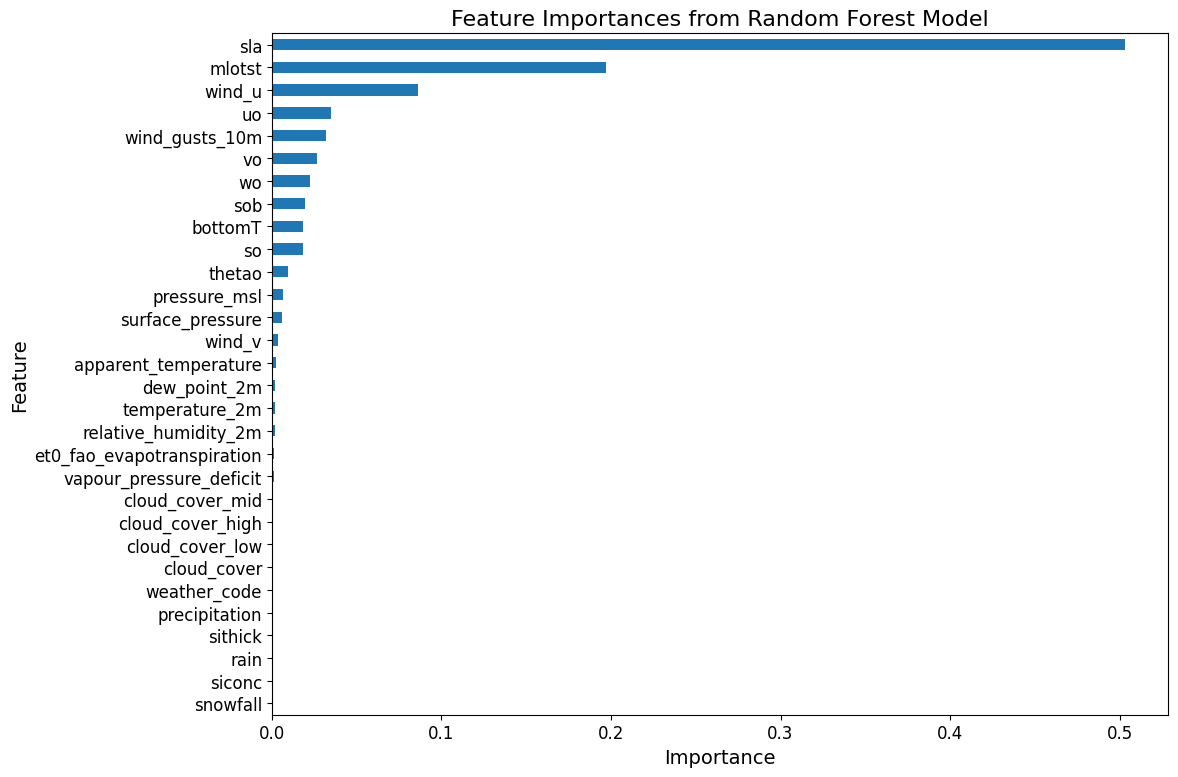

In [19]:
# Barchart der Feature-Wichtigkeiten
plt.figure(figsize=(12, 8))
feature_importances_grouped.plot(kind='barh', x='feature', y='importance', ax=plt.gca(), legend=False)
plt.title("Feature Importances from Random Forest Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()

In [20]:
# filter lower then 0.01
feature_importances_grouped_filtered = feature_importances_grouped[feature_importances_grouped['importance'] < 0.005]

print(feature_importances_grouped_filtered['feature'].to_list())

# filter greater then 0.01
feature_importances_grouped_filtered = feature_importances_grouped[feature_importances_grouped['importance'] > 0.005]
features_list = feature_importances_grouped_filtered['feature'].to_list()
print(features_list)

['snowfall', 'siconc', 'rain', 'sithick', 'precipitation', 'weather_code', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_high', 'cloud_cover_mid', 'vapour_pressure_deficit', 'et0_fao_evapotranspiration', 'relative_humidity_2m', 'temperature_2m', 'dew_point_2m', 'apparent_temperature', 'wind_v']
['surface_pressure', 'pressure_msl', 'thetao', 'so', 'bottomT', 'sob', 'wo', 'vo', 'wind_gusts_10m', 'uo', 'wind_u', 'mlotst', 'sla']


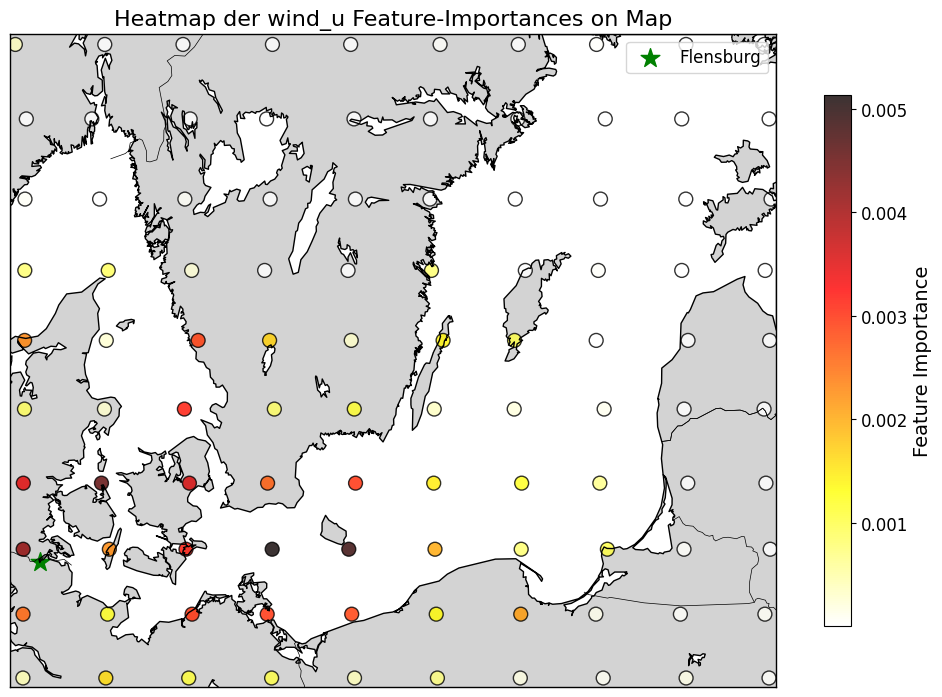

In [22]:

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

def plot_feature_importance_heatmap(df: pd.DataFrame, feature:str):

    df = df[df['feature'] == feature]

    p = 0.1
    plt.figure(figsize=(10, 8))
    m = Basemap(
        projection='merc',
        llcrnrlat=df['latitude'].min() - p,
        urcrnrlat=df['latitude'].max() + p,
        llcrnrlon=df['longitude'].min() - p,
        urcrnrlon=df['longitude'].max() + p,
        resolution='i'
    )
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='white')
    m.fillcontinents(color='lightgray', lake_color='white')

    # Punkte in Karten-Koordinaten umrechnen
    x, y = m(df['longitude'].values, df['latitude'].values)

    # Heatmap: Streudiagramm mit Farbe nach Importance
    sc = m.scatter(x, y, c=df['importance'], cmap='hot_r', s=100, edgecolor='k', alpha=0.8)
    target_lat = 54.7959974146437
    target_lon = 9.434913246104081
    x_target, y_target = m(target_lon, target_lat)
    m.scatter(x_target, y_target, color="green", marker="*", label="Flensburg", s=200)

    cbar = plt.colorbar(sc, shrink=0.7, pad=0.05)
    cbar.set_label('Feature Importance')
    plt.title(f'Heatmap der {feature} Feature-Importances on Map')
    plt.tight_layout()
    plt.legend(loc='upper right')
    plt.show()

plot_feature_importance_heatmap(feature_importances_df, feature='wind_u')



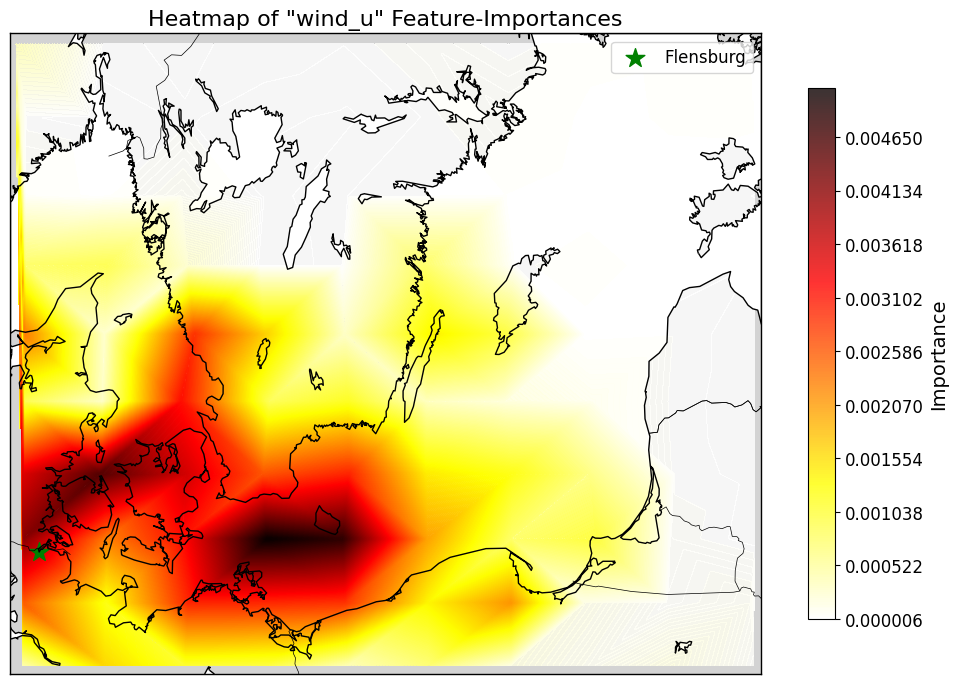

In [25]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

def plot_feature_importance_contour(df: pd.DataFrame, feature: str):
    df = df[df['feature'] == feature]
    
    p = 0.1
    # Basemap Setup
    plt.figure(figsize=(10, 8))
    m = Basemap(
        projection='merc',
        llcrnrlat=df['latitude'].min() - p,
        urcrnrlat=df['latitude'].max() + p,
        llcrnrlon=df['longitude'].min() - p,
        urcrnrlon=df['longitude'].max() + p,
        resolution='i'
    )

    if feature in WEATHER_DICT.keys():
        m.drawcoastlines()
        m.drawcountries()
        m.fillcontinents(color='lightgray')
        m.drawmapboundary()
    
    # Original-Punkte
    lon = df['longitude'].values
    lat = df['latitude'].values
    imp = df['importance'].values
    
    # 1) Erstelle regelmäßiges Gitter in lon/lat
    xi = np.linspace(lon.min(), lon.max(), 500)
    yi = np.linspace(lat.min(), lat.max(), 500)
    xi, yi = np.meshgrid(xi, yi)
    
    # 2) Interpoliere die Importance-Werte aufs Gitter
    zi = griddata((lon, lat), imp, (xi, yi), method='linear')
    
    # 3) In Karten-Koordinaten umwandeln
    xg, yg = m(xi, yi)
    
    # 4) Kontur-Füllung zeichnen
    cs = m.contourf(xg, yg, zi, levels=900, cmap='hot_r', alpha=0.8)
    cbar = plt.colorbar(cs, shrink=0.7, pad=0.05)
    cbar.set_label('Importance')

    if feature in OCEAN_DICT.keys():
        m.drawcoastlines()
        m.drawcountries()
        m.fillcontinents(color='lightgray')
        m.drawmapboundary()

    target_lat = 54.7959974146437
    target_lon = 9.434913246104081
    x_target, y_target = m(target_lon, target_lat)
    m.scatter(x_target, y_target, color="green", marker="*", label="Flensburg", s=200)


    plt.title(f'Heatmap of "{feature}" Feature-Importances')
    plt.tight_layout()
    plt.legend(loc='upper right')
    plt.show()

plot_feature_importance_contour(feature_importances_df, feature='wind_u')

In [ ]:

for feature in features_list:
    if feature in WEATHER_DICT.keys():
        plot_feature_importance_contour(feature_importances_df, feature=feature)
    else: 
        plot_feature_importance_heatmap(feature_importances_df, feature=feature)


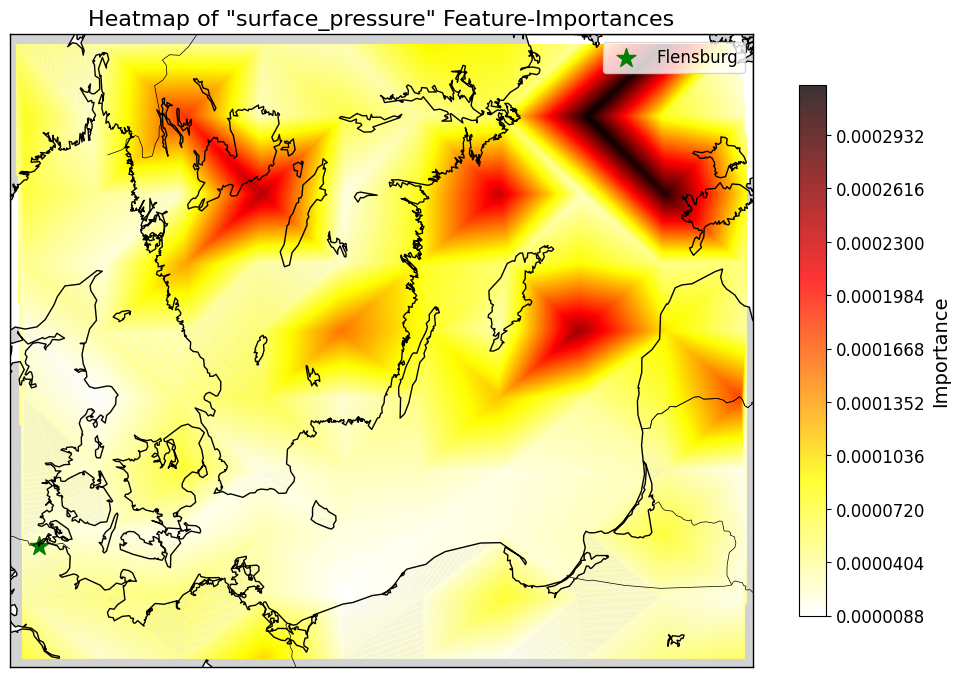

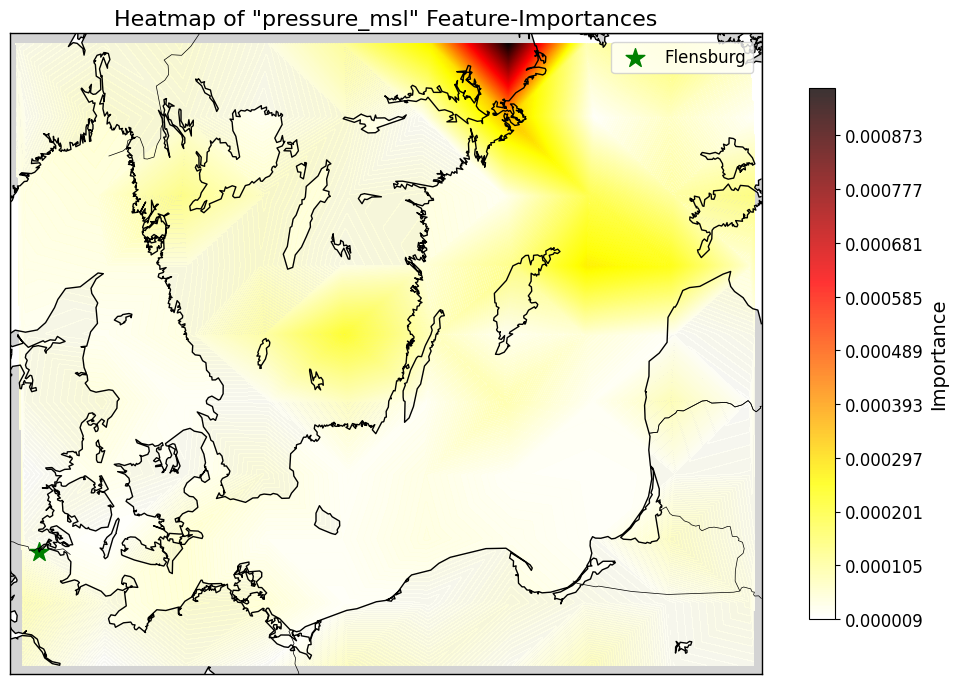

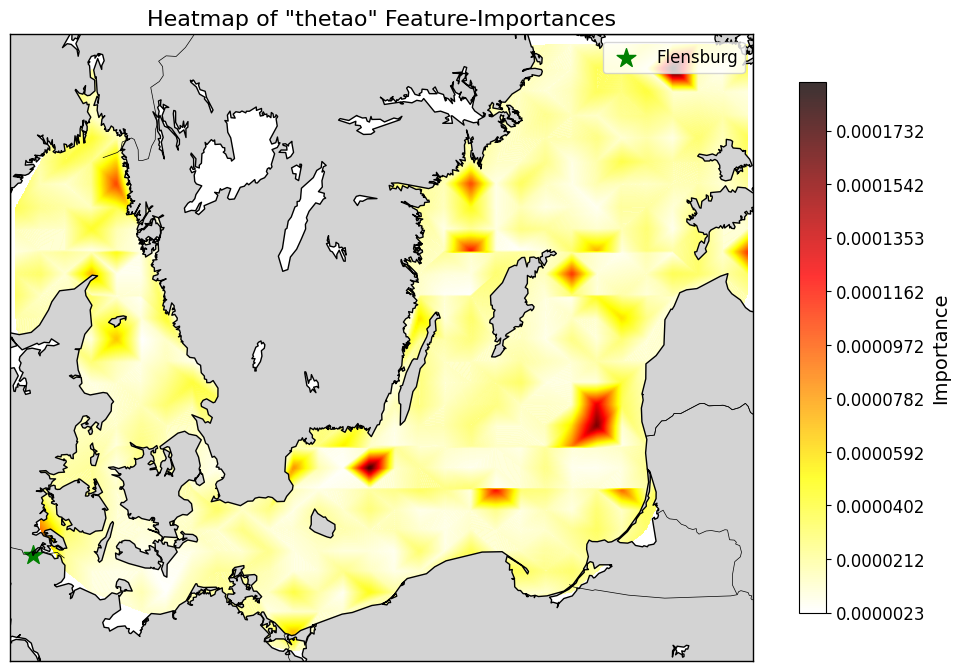

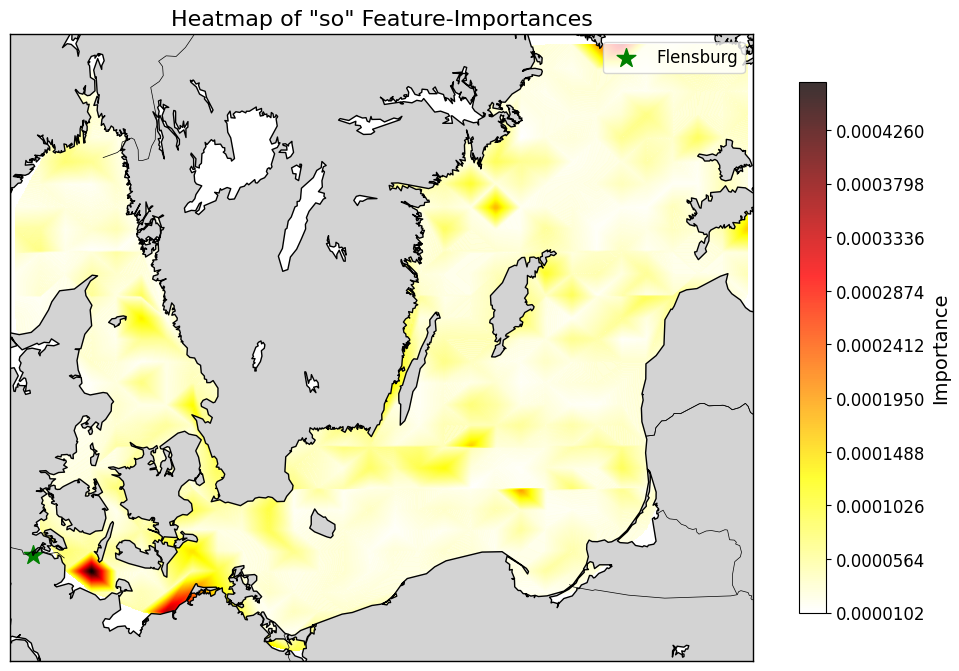

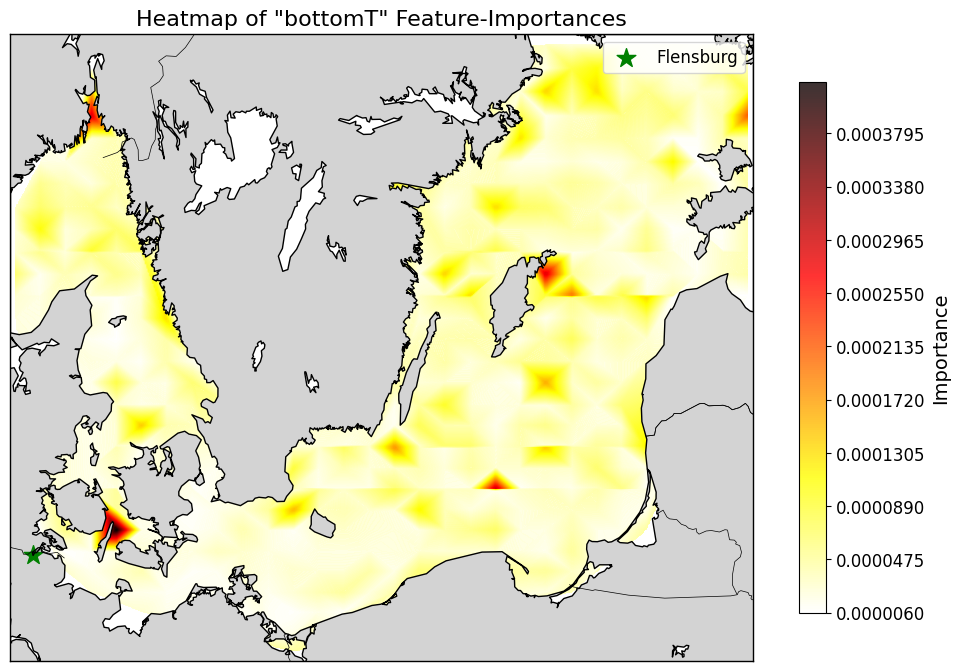

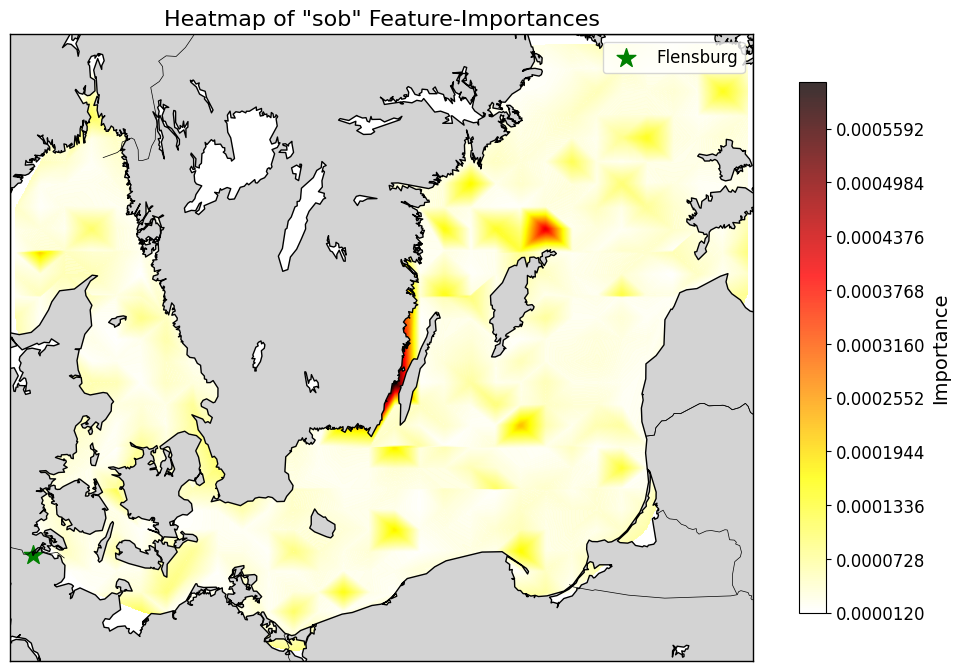

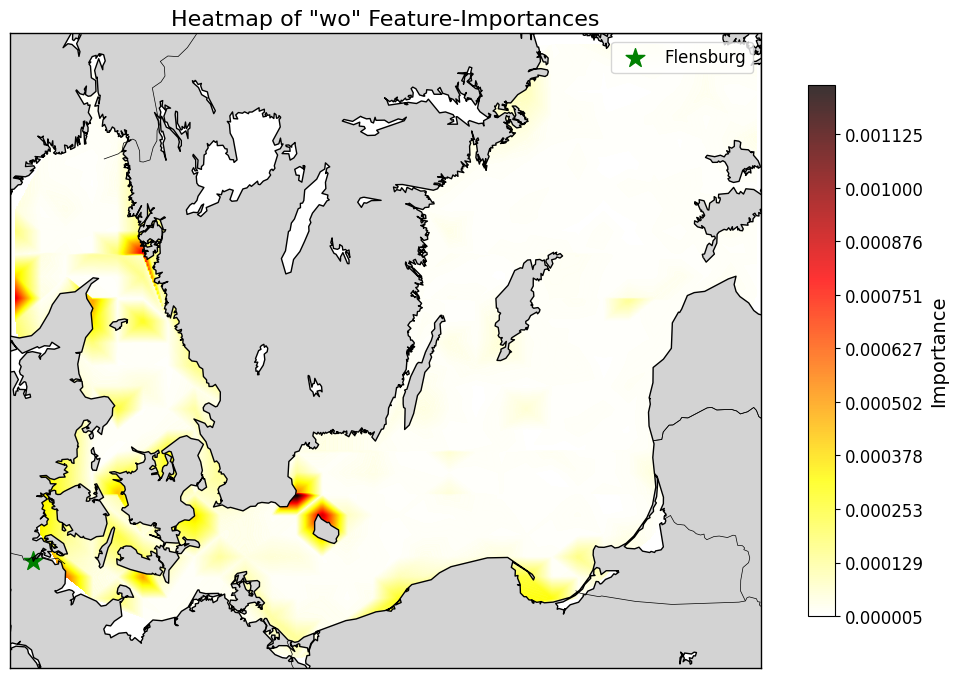

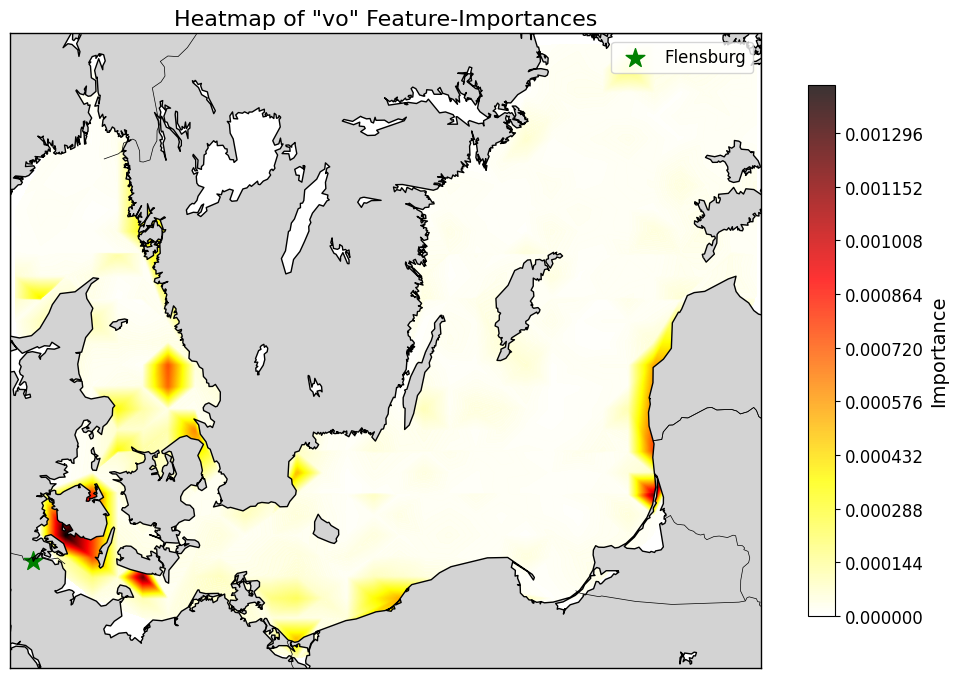

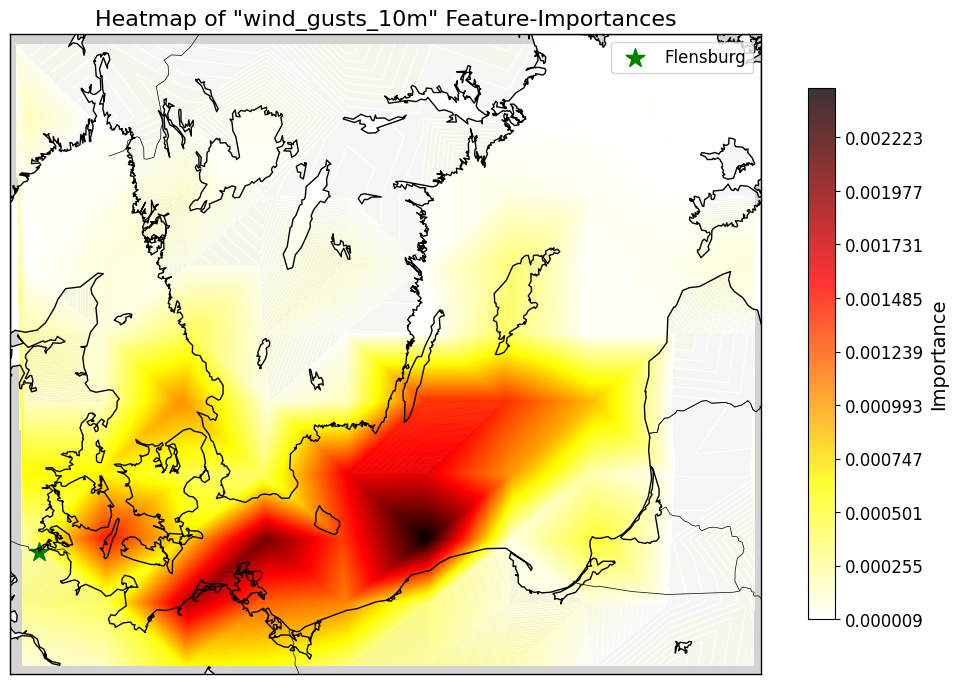

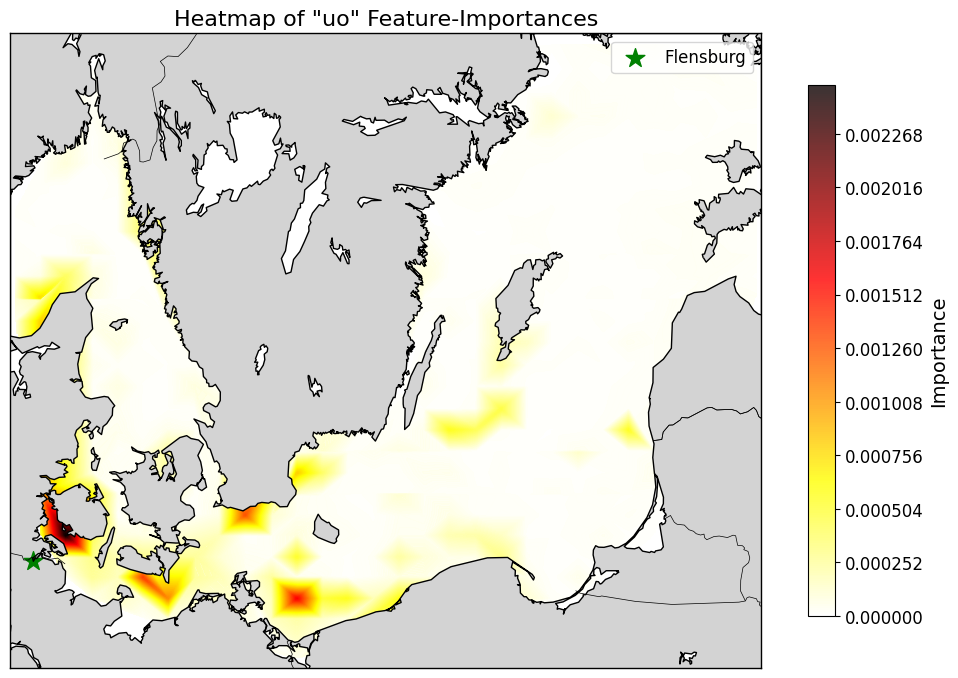

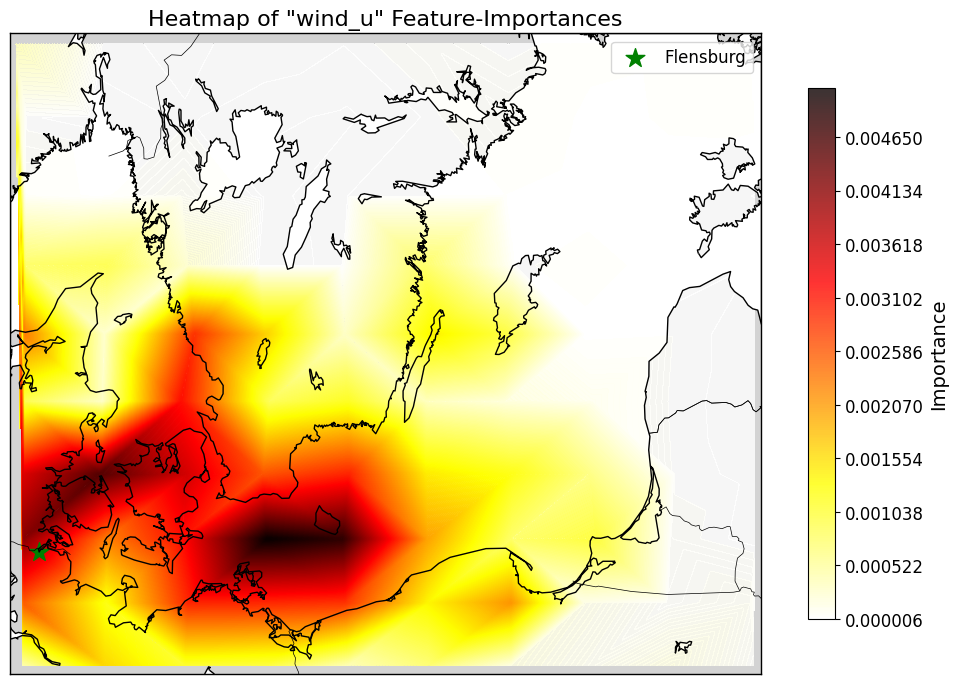

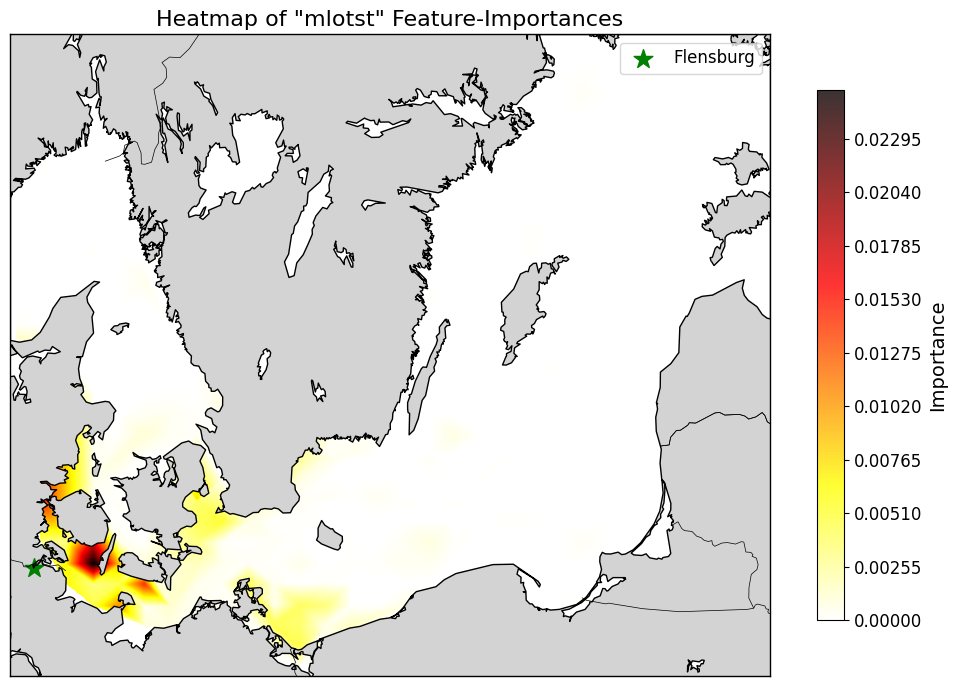

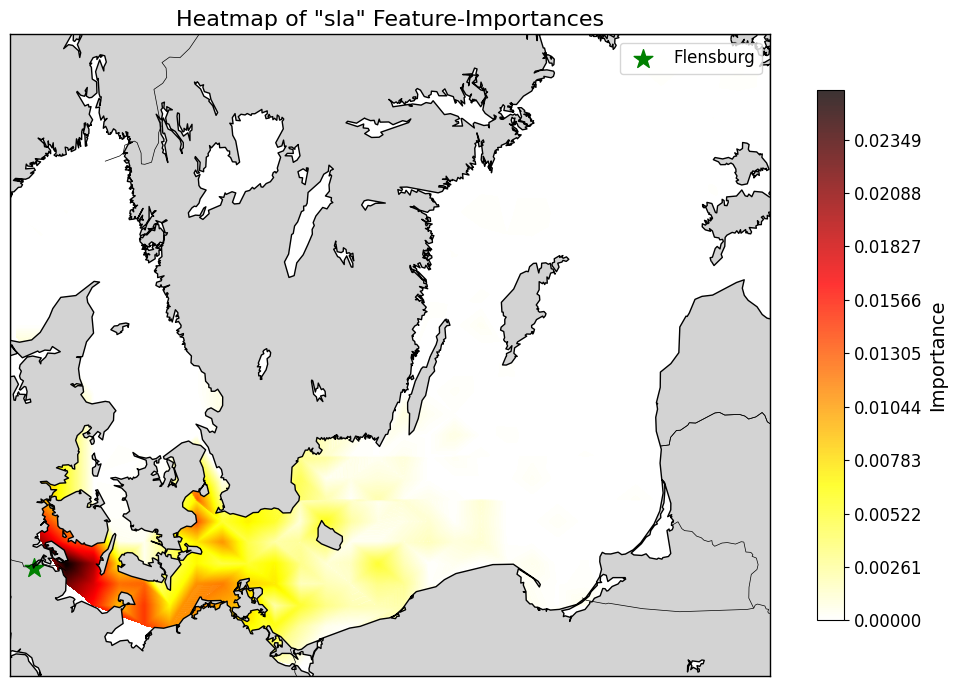

In [26]:
for feature in features_list:
    plot_feature_importance_contour(feature_importances_df, feature=feature)


In [ ]:
plot_feature_importance_contour(feature_importances_df, feature='pressure_msl')

# Archive

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def time_series_split_eval(model=RandomForestRegressor(), X=None, y=None, n_splits=2, verbose=False):
    """
    Perform time series cross-validation and evaluate the model.
    """
    # 3) TimeSeriesSplit konfigurieren
    
    tscv = TimeSeriesSplit(n_splits=n_splits)


    # 5) Cross-Validation laufen lassen and MSE pro Fold berechnen
    mse_scores = []

    for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Modell fitten
        model.fit(X_train, y_train)
        # Vorhersage
        y_pred = model.predict(X_test)
        # MSE berechnen
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)


    if verbose:
        print("\nMSE pro Fold:")
        for fold, mse in enumerate(mse_scores, 1):
            print(f"Fold {fold}: MSE = {mse:.4f}")
        # 6) Durchschnittlichen MSE berechnen
        print("\nDurchschnittlicher MSE über alle Folds: "
            f"{np.mean(mse_scores):.4f}")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1) Daten erzeugen: ein einfaches, univariates Zeit­reihen­signal
np.random.seed(42)
n_samples = 100
time = np.arange(n_samples)
# Trend + Rauschen
y = 0.05 * time + np.sin(time / 5) + np.random.normal(scale=0.5, size=n_samples)

# In ein DataFrame packen (optional, aber oft praktisch)
df = pd.DataFrame({'t': time, 'y': y})

# 2) Merkmals-Matrix X und Ziel y definieren
#    Hier nur die Zeitindizes als Feature – in der Praxis nutzt du natürlich mehr
X = df[['t']].values
y = df['y'].values

time_series_split_eval(
    model=LinearRegression(),
    X=X,
    y=y,
    n_splits=2,
    verbose=True
)


In [ ]:
dd

In [ ]:
import pandas as pd
import numpy as np


def generate_random_ocean_data():
    # Zeitstempel generieren (stündlich von 2023-01-01 bis 2025-03-01)
    time_index = pd.date_range(start="2023-01-01", end="2025-03-01", freq="H")

    # Beispiel-Koordinaten (Breitengrad, Längengrad)
    coordinates = [
        (54.32, 10.14),  # Kiel, Deutschland
        (60.39, 5.32),   # Bergen, Norwegen
        (36.85, -6.27),  # Cádiz, Spanien
        (-33.87, 151.21) # Sydney, Australien
    ]

    # Funktion zur Generierung realistischer Ozeandaten mit saisonalen Schwankungen
    def generate_ocean_data(time_index):
        n = len(time_index)
        t = np.arange(n)

        # Jahreszeitliche Schwankungen simulieren (Sinus-Funktion)
        seasonality = np.sin(2 * np.pi * t / (24 * 365))  # Jahresperiode

        # Wassertemperatur (°C) mit saisonalen Schwankungen
        water_temp = 10 + 5 * seasonality + np.random.normal(0, 1, n)

        # Wasserhöhe (m) mit zufälligen Schwankungen (Gezeiten)
        water_height = 1.5 + 0.5 * np.sin(2 * np.pi * t / (12)) + np.random.normal(0, 0.2, n)

        # Windgeschwindigkeit (m/s) mit variablen Böen
        wind_speed = 5 + 2 * np.cos(2 * np.pi * t / (24 * 7)) + np.random.normal(0, 1, n)

        return water_temp, water_height, wind_speed

    # DataFrame erstellen
    data = []

    for lat, lon in coordinates:
        water_temp, water_height, wind_speed = generate_ocean_data(time_index)
        df = pd.DataFrame({
            "timestamp": time_index,
            "latitude": lat,
            "longitude": lon,
            "water_temperature": water_temp,
            "water_height": water_height,
            "wind_speed": wind_speed
        })
        data.append(df)

    # Alle Daten zusammenführen
    ocean_data = pd.concat(data, ignore_index=True)
    return ocean_data


In [ ]:
#ocean_data = df.copy()
# Erstellen der 'position'-Spalte als Tupel aus 'latitude' und 'longitude'
ocean_data['position'] = ocean_data.apply(lambda row: (row['latitude'], row['longitude']), axis=1)
ocean_data.rename(columns={'timestamp': 'time'}, inplace=True)
ocean_data

In [ ]:
coordinates = ocean_data['position'].unique()
print(len(coordinates))  # Anzahl der einzigartigen Koordinaten
coordinates

In [ ]:
df_merged = pd.DataFrame({'time': ocean_data['time'].unique()})

for i in range(len(coordinates)):

    ocean_sub_data = ocean_data.loc[ocean_data['position'] == coordinates[i]]

    ocean_sub_data = ocean_sub_data.drop(columns=['latitude', 'longitude'])
   # display(ocean_sub_data)
    cols = ocean_sub_data.columns.to_list()

    cols.remove('time')
    cols.remove('position')

    

    for col in cols:
        ocean_sub_data.rename(columns={col: col + '_' + str(coordinates[i])}, inplace=True)

    ocean_sub_data = ocean_sub_data.drop(columns='position')


    df_merged = df_merged.merge(ocean_sub_data, on='time')
display(df_merged)
    
    

In [ ]:
# Hier weiter machene, group by hour

In [ ]:
target_file = 'data/NO_TS_TG_KielHoltenauTG.nc'
ds = xr.open_dataset(target_file)
df_target = ds.to_dataframe()
df_target = df_target.reset_index()
df_target

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

df = df_merged.copy()

# Setze das Zielvariable (z.B. Wassertemperatur in Kiel, 54.32, 10.14)
target_column = "water_temperature_(54.32, 10.14)"
X = df.drop(columns=["time", target_column])  # Features
y = df[target_column]  # Zielvariable

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Modell trainieren
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature Importance abrufen
importances = rf.feature_importances_

# Als DataFrame darstellen
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)



In [ ]:
# Anzeigen der wichtigsten Features
display(feature_importance_df.head(10))

In [ ]:
from sklearn.inspection import permutation_importance

# Berechnung der Permutations-Feature-Importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# DataFrame erstellen
perm_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": result.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by="Importance", ascending=False)

print(perm_importance_df.head(10))


In [ ]:
import shap

# SHAP-Explainer für Random Forest
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)




In [ ]:
# Wasserfall-Plot für ein Beispiel
shap.plots.waterfall(shap_values[0])

In [ ]:
import optuna.visualization as vis

# Verlauf der Optimierung (Zielwert pro Trial)
fig1 = vis.plot_optimization_history(study)
fig1.show()

# Wichtigkeit der Hyperparameter
fig2 = vis.plot_param_importances(study)
fig2.show()